In [1]:
# 1. Imports
# ============================
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


# ============================
# 2. Device Config
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# 3. Dataset & Dataloaders
# ============================
data_dir = "/kaggle/input/cucumber-disease-augmented-dataset/Augmented Image"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split (80% train, 10% val, 10% test)
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot']
Train: 5120, Val: 640, Test: 640


In [3]:
# 4. CBAM Module
# ============================
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.relu:
            x = self.relu(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out


In [4]:
# ============================
# 5. Model with CBAM
# ============================
def build_model(num_classes):
    base_model = models.densenet169(weights="IMAGENET1K_V1")

    class DenseNet_CBAM(nn.Module):
        def __init__(self, base_model, num_classes):
            super(DenseNet_CBAM, self).__init__()
            self.features = base_model.features
            self.cbam = CBAM(1664)  # DenseNet-169 final feature maps = 1664
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.classifier = nn.Linear(1664, num_classes)

        def forward(self, x):
            x = self.features(x)
            x = self.cbam(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

    return DenseNet_CBAM(base_model, num_classes).to(device)

In [5]:
# ============================
# 6. Training Function
# ============================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc  = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        loop_val = tqdm(val_loader, desc=f"Val {epoch+1}/{epochs}", leave=False)

        with torch.no_grad():
            for images, labels in loop_val:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                loop_val.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [6]:
# ============================
# 7. Evaluation Function
# ============================
def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return acc, prec, rec, f1, y_true, y_pred, cm

In [7]:
# ============================
# 8. Train & Evaluate
# ============================
num_epochs = 10
model = build_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)

final_acc, final_prec, final_rec, final_f1, y_true, y_pred, cm = evaluate_model(
    model, test_loader, class_names, device
)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 230MB/s]



Epoch 1/10


Epoch 1/10 - Train Loss: 0.4302, Train Acc: 0.8951, Val Loss: 0.0558, Val Acc: 0.9797

Epoch 2/10


Epoch 2/10 - Train Loss: 0.0411, Train Acc: 0.9889, Val Loss: 0.0232, Val Acc: 0.9938

Epoch 3/10


Epoch 3/10 - Train Loss: 0.0239, Train Acc: 0.9938, Val Loss: 0.0345, Val Acc: 0.9828

Epoch 4/10


Epoch 4/10 - Train Loss: 0.0125, Train Acc: 0.9973, Val Loss: 0.0261, Val Acc: 0.9938

Epoch 5/10


Epoch 5/10 - Train Loss: 0.0155, Train Acc: 0.9955, Val Loss: 0.0275, Val Acc: 0.9906

Epoch 6/10


Epoch 6/10 - Train Loss: 0.0077, Train Acc: 0.9980, Val Loss: 0.0202, Val Acc: 0.9922

Epoch 7/10


Epoch 7/10 - Train Loss: 0.0069, Train Acc: 0.9980, Val Loss: 0.0519, Val Acc: 0.9812

Epoch 8/10


Epoch 8/10 - Train Loss: 0.0134, Train Acc: 0.9963, Val Loss: 0.0250, Val Acc: 0.9906

Epoch 9/10


Epoch 9/10 - Train Loss: 0.0065, Train Acc: 0.9980, Val Loss: 0.0086, Val Acc: 0.9969

Epoch 10/10


Epoch 10/10 - Train Loss: 0.0066, Train Acc: 0.9979, Val Loss: 0.0297, Val Acc: 0.9906


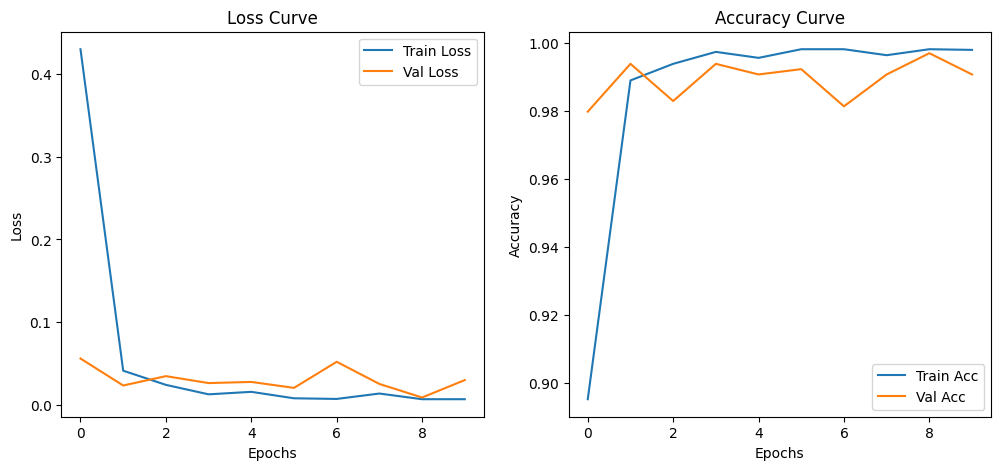

In [8]:

# ============================
# 9. Plots
# ============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()


COMPREHENSIVE CONFUSION MATRIX


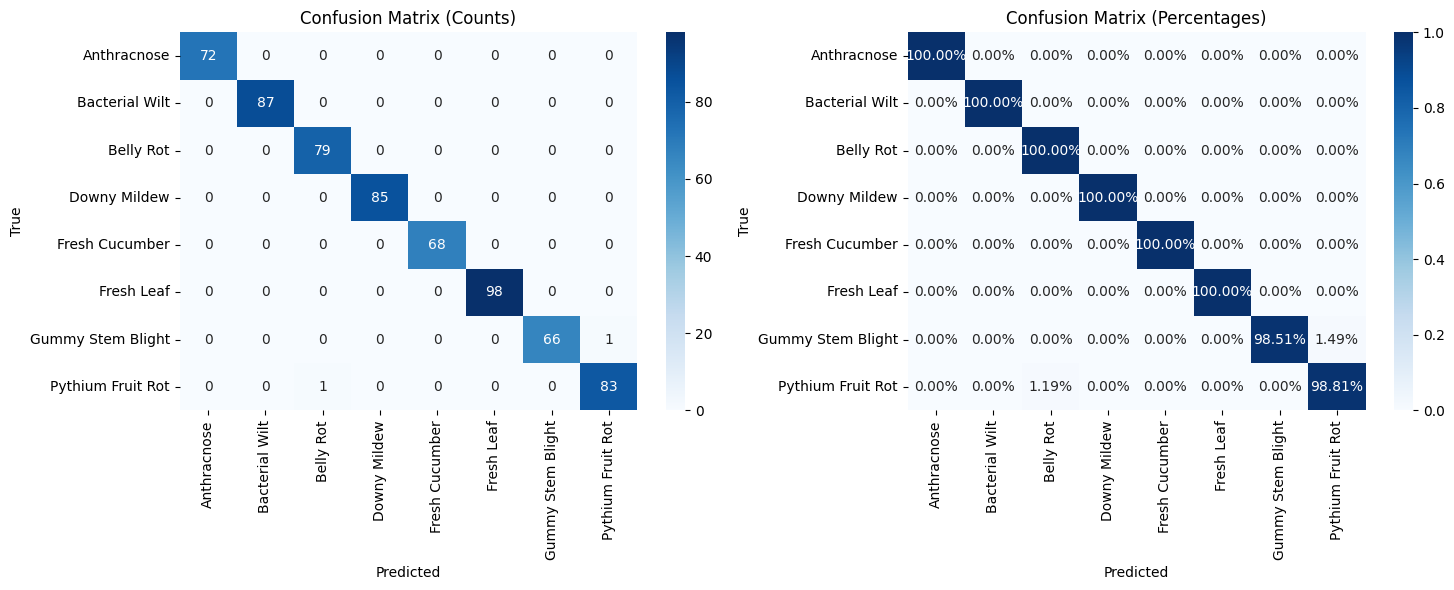

In [9]:
# ============================


# ============================


# ============================















# ============================
# 10. Confusion Matrix
# ============================
print("\n" + "="*50)
print("COMPREHENSIVE CONFUSION MATRIX")
print("="*50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
ax1.set_title("Confusion Matrix (Counts)")

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names)
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")
ax2.set_title("Confusion Matrix (Percentages)")

plt.tight_layout()
plt.show()




In [10]:
# ============================
# 11. Final Metrics
# ============================
print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)
print(f"{'Accuracy':<12} {final_acc:.4f}")
print(f"{'Precision':<12} {final_prec:.4f}")
print(f"{'Recall':<12} {final_rec:.4f}")
print(f"{'F1-Score':<12} {final_f1:.4f}")

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))



FINAL METRICS SUMMARY
Accuracy     0.9969
Precision    0.9969
Recall       0.9966
F1-Score     0.9968

DETAILED CLASSIFICATION REPORT
                   precision    recall  f1-score   support

      Anthracnose     1.0000    1.0000    1.0000        72
   Bacterial Wilt     1.0000    1.0000    1.0000        87
        Belly Rot     0.9875    1.0000    0.9937        79
     Downy Mildew     1.0000    1.0000    1.0000        85
   Fresh Cucumber     1.0000    1.0000    1.0000        68
       Fresh Leaf     1.0000    1.0000    1.0000        98
Gummy Stem Blight     1.0000    0.9851    0.9925        67
Pythium Fruit Rot     0.9881    0.9881    0.9881        84

         accuracy                         0.9969       640
        macro avg     0.9969    0.9966    0.9968       640
     weighted avg     0.9969    0.9969    0.9969       640

